In [1]:
using KomaMRI, MAT, Plots, LinearAlgebra, Measures

sys = Scanner()
sim_params = KomaMRICore.default_sim_params()
sim_params["return_type"] = "mat"
sim_params["sim_method"] = BlochDict()
sim_params["gpu"] = false

seq = read_seq("sequences/mpf_001_PhantomStudy_short_124.seq")

┌ Info: Loading sequence mpf_001_PhantomStudy_short_124.seq ...
└ @ KomaMRIFiles C:\Users\lucya\.julia\packages\KomaMRIFiles\Xc9Fh\src\Sequence\Pulseq.jl:339


Sequence[ τ = 5117.377 ms | blocks: 2003 | ADC: 1000 | GR: 6001 | RF: 962 | DEF: 11 ]

In [2]:
T1_ms, T2_ms = 2573.7, 903.27
# T1_ms, T2_ms = 1612.1, 271    # vial 4
#T1_ms, T2_ms = 1050, 140   # vial 6
T1, T2 = T1_ms / 1000, T2_ms / 1000

(2.5736999999999997, 0.90327)

In [3]:
x_pos = collect(range(-10e-3, 10e-3, length=10001))
obj = Phantom{Float64}(
    x = x_pos,
    y = zeros(length(x_pos)),
    z = zeros(length(x_pos)),
    T1 = fill(T1, length(x_pos)),
    T2 = fill(T2, length(x_pos)),
)

sig = simulate(obj, seq, sys; sim_params=sim_params)
sig_clean = dropdims(sig; dims=(3,4))

┌ Info: Simulation will be run on the CPU with only 1 thread. To enable multi-threading, start julia with --threads=auto
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:335
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = BlochDict(save_Mz=false)
│   spins = 10001
│   time_points = 42523
│   adc_points = 1000
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...   0%|█                             |  ETA: 3:05:02


Running simulation...   1%|█                             |  ETA: 0:24:32


Running simulation...   1%|█                             |  ETA: 0:14:34


Running simulation...   2%|█                             |  ETA: 0:11:48


Running simulation...   2%|█                             |  ETA: 0:09:42


Running simulation...   3%|█                             |  ETA: 0:08:24


Running simulation...   3%|█             

 41.278589 seconds (21.83 M allocations: 26.416 GiB, 8.43% gc time, 31.65% compilation time: <1% of which was recompilation)


1000×10001 Matrix{ComplexF32}:
  -0.0157758-0.0165878im   …     0.017165-0.0121589im
  0.00221193-0.0227955im       0.00197053-0.0208435im
   0.0190487-0.0137931im       -0.0148097-0.0155524im
   0.0239068+0.004576im        -0.0223527+0.000285053im
    0.013739+0.0204612im       -0.0158443+0.016441im
 -0.00467034+0.0236536im   …  0.000307848+0.0224996im
  -0.0193297+0.0122857im        0.0155548+0.0147115im
  -0.0207625-0.0061074im        0.0200078-0.00170979im
 -0.00817474-0.0195136im        0.0108937-0.0160077im
   0.0101764-0.019291im        -0.0057794-0.0189313im
            ⋮              ⋱             ⋮
  0.00157919+0.00258378im     -0.00157101+0.0025686im
  0.00192705+0.00250237im     -0.00193267+0.00248615im
  0.00219141+0.00270619im     -0.00220708+0.00269937im
  0.00218098+0.00304233im     -0.00219655+0.00304921im
  0.00188867+0.00326647im  …  -0.00189414+0.00328249im
  0.00149841+0.00320747im     -0.00149039+0.00322226im
  0.00122985+0.00288888im     -0.00121364+0.00289296im


In [ ]:
using Plots, LaTeXStrings

t_indices = [1, 10, 50, 100, 250, 500, 750, 1000]
x_pos_mm = x_pos .* 1000

plot_list = []

# Consistent axes
xlims = (-10, 10)
y_max = maximum([maximum(abs.(sig_clean[t, :])) for t in t_indices]) * 1.05
ylims = (0.0, y_max)

for (i, t_idx) in enumerate(t_indices)
    Mmag = abs.(sig_clean[t_idx, :])

    # Label only bottom row / left column
    xlabel = i > 4 ? L"x\ \mathrm{(mm)}" : ""
    ylabel = (i-1) % 4 == 0 ? L"|M_{yz}|" : ""

    p = plot(
        x_pos_mm, Mmag,
        lw=1.6, color=:blue, label="",
        #xlims=xlims, ylims=ylims,
        xlabel=xlabel, ylabel=ylabel,
        title=L"TR = %$t_idx", titlefont=11,
        tickfont=9, guidefont=10,
        framestyle=:box,
        left_margin=6mm, right_margin=3mm,
        bottom_margin=6mm, top_margin=3mm,
        dpi=200
    )
    push!(plot_list, p)
end

p_all = plot(
    plot_list...;
    layout=(2,4),
    size=(1200,500),     # wide enough for labels
    margin=1mm           # small spacing *between* subplots
)

# Plots.savefig(p_all, "transverse_magnetisation.pdf")


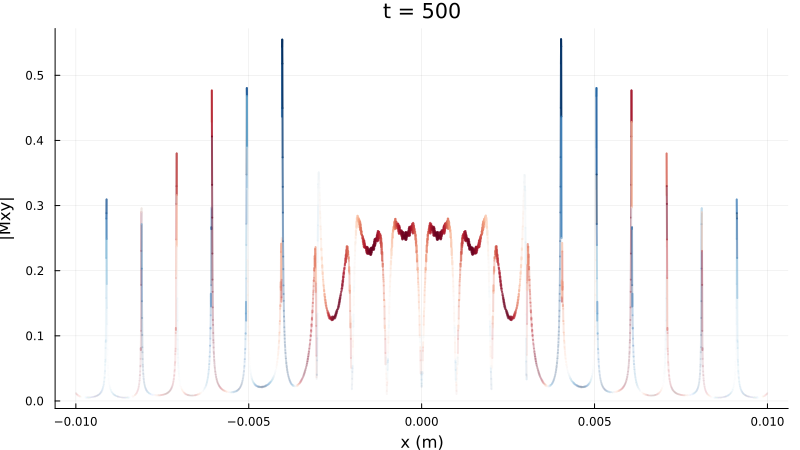

In [ ]:
# using Plots, Colors
# default(size=(800,450))

# # Data you have
# t_idx  = 500
# Mxy_t  = sig_clean[t_idx, :]          # Complex{T} along x_pos
# x      = x_pos
# mag    = abs.(Mxy_t)
# ϕ      = angle.(Mxy_t)

# # --- pick a reference phase (example: angle of the net signal inside ±5 mm)
# mask = abs.(x) .<= 5e-3
# ref_phase = angle(sum(Mxy_t[mask]))   # main signal phase

# # Phase agreement metric in [-1,1]: +1=in-phase, -1=opposite
# Δϕ = ϕ .- ref_phase
# Δϕ = atan.(sin.(Δϕ), cos.(Δϕ))       # wrap to [-π, π]
# agree = cos.(Δϕ)                      # map to [-1,1]

# # Colormap: red=positive (in-phase), blue=negative (out-of-phase)
# cmap = cgrad(:RdBu_11, rev=true)

# # Precompute normalization for alpha (brightness by local magnitude)
# α = mag ./ maximum(mag)

# plt = plot(xlabel="x (m)", ylabel="|Mxy|", title="t = $t_idx", legend=false)
# for i in 1:length(x)-1
#     # map agree[i] from [-1,1] -> [0,1] to sample the gradient
#     u = (agree[i] + 1) / 2
#     col = get(cmap, u)                # a Colorant (not a vector)
#     plot!(plt, x[i:i+1], mag[i:i+1],
#           color=col, alpha=α[i], lw=2)
# end
# plt


In [ ]:
using Plots

Plots.reset_defaults()
default(size=(700, 400), dpi=200, framestyle=:box,
        guidefont=font(11), tickfont=font(9), legend=false)

wrapπ(θ) = atan(sin(θ), cos(θ))
function colored_curve!(plt, x, y, agree; cmap=cgrad(:RdBu_11, rev=true), α=ones(length(x)), lw=2)
    for i in 1:length(x)-1
        u   = (agree[i] + 1) / 2
        col = get(cmap, u)
        plot!(plt, x[i:i+1], y[i:i+1], color=col, alpha=α[i], lw=lw)
    end
end

# function plot_mxy_phase_full(x_m, Mxy_t; ref_half_mm=5.0)
#     x_mm = x_m .* 1e3
#     mag  = abs.(Mxy_t)
#     ϕ    = angle.(Mxy_t)

#     mask_ref  = abs.(x_mm) .<= ref_half_mm
#     ref_phase = angle(sum(Mxy_t[mask_ref]))

#     Δϕ    = wrapπ.(ϕ .- ref_phase)
#     agree = cos.(Δϕ)

#     α_full = 0.2 .+ 0.8 .* (mag ./ maximum(mag))
#     cmap   = cgrad(:RdBu_11, rev=true)

#     plt = plot(xlabel=L"x\ \mathrm{(mm)}", ylabel=L"|M_{yz}|")
#     colored_curve!(plt, x_mm, mag, agree; cmap=cmap, α=α_full, lw=2)
#     scatter!(plt, x_mm, mag;
#              markeralpha=α_full, markerstrokecolor=:black, markerstrokewidth=0.2, ms=3,
#              markercolor=get.(Ref(cmap), (agree .+ 1)./2))

#     return plt
# end

function plot_mxy_phase_full(x_m, Mxy_t; ref_half_mm=5.0)
    x_mm = x_m .* 1e3
    mag  = abs.(Mxy_t)
    ϕ    = angle.(Mxy_t)

    mask_ref  = abs.(x_mm) .<= ref_half_mm
    ref_phase = angle(sum(Mxy_t[mask_ref]))

    Δϕ    = wrapπ.(ϕ .- ref_phase)
    agree = cos.(Δϕ)

    α_full = 0.2 .+ 0.8 .* (mag ./ maximum(mag))
    cmap   = cgrad(:RdBu_11, rev=true)

    plt = plot(xlabel=L"x\ \mathrm{(mm)}", ylabel=L"|M_{yz}|", rightmargin=4mm, leftmargin = 2mm)
    colored_curve!(plt, x_mm, mag, agree; cmap=cmap, α=α_full, lw=2)
    scatter!(plt, x_mm, mag;
             markeralpha=α_full, markerstrokecolor=:black, markerstrokewidth=0.2, ms=3,
             markercolor=get.(Ref(cmap), (agree .+ 1)./2))

    # add dummy scatter to trigger colorbar
    scatter!(plt, x_mm, mag;
             zcolor=agree, c=cmap, clims=(-1,1),
             markerstrokecolor=:transparent, markeralpha=0.0,
             colorbar=true,
             colorbar_titlefont=font(9), colorbar_tickfont=font(4))

    return plt
end




# ----------------- usage -----------------
Mxy_t = sig_clean[t_idx, :]
fig = plot_mxy_phase_full(x_pos, Mxy_t; ref_half_mm=5.0)
Plots.savefig(fig, "transverse_phase.pdf")



"c:\\Users\\lucya\\MSC_PROJECT\\Dictionary\\transverse_phase.pdf"

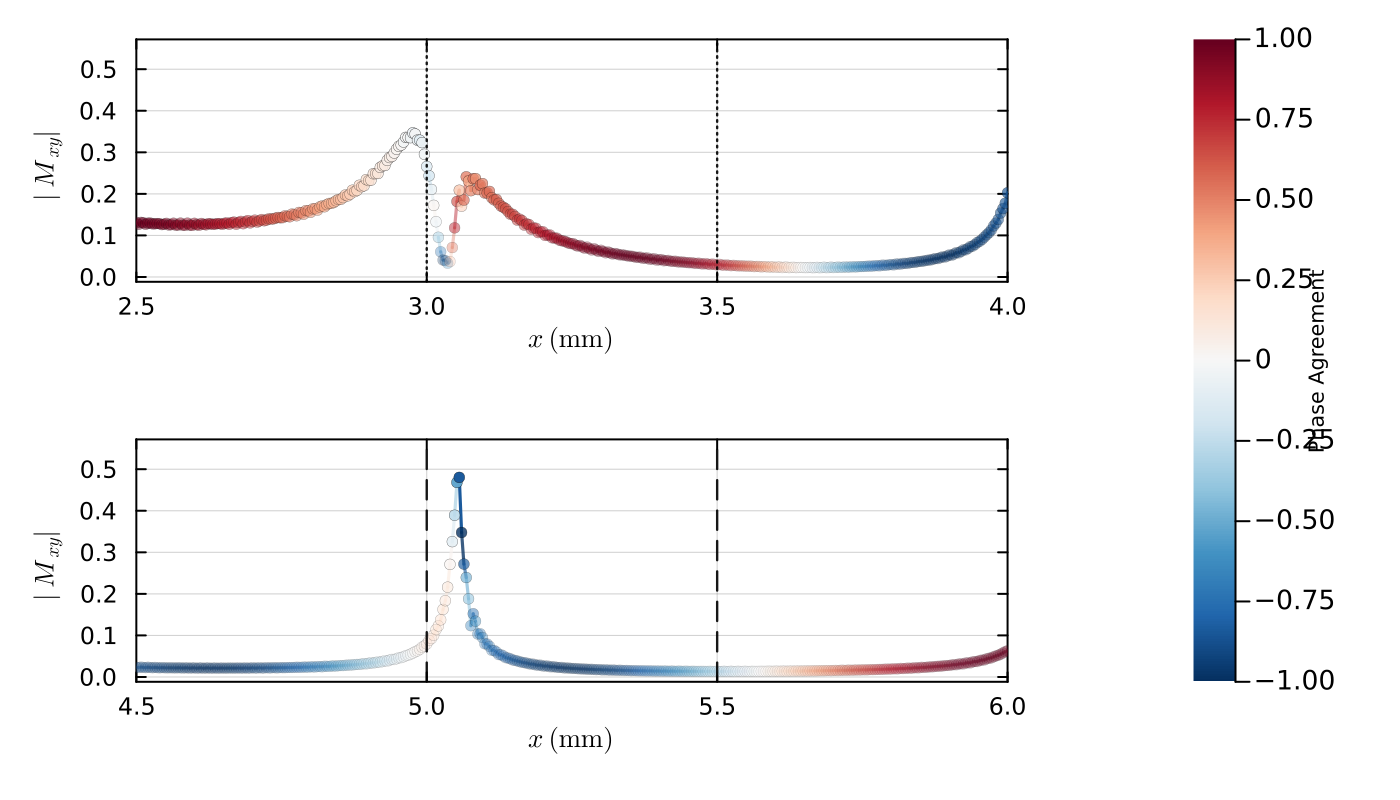

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [ ]:
# function plot_twozooms_with_colorbar(x_m, Mxy_t)
#     x_mm = x_m .* 1e3
#     mag  = abs.(Mxy_t)
#     ϕ    = angle.(Mxy_t)

#     mask_ref  = abs.(x_mm) .<= 5.0
#     ref_phase = angle(sum(Mxy_t[mask_ref]))
#     Δϕ    = wrapπ.(ϕ .- ref_phase)
#     agree = cos.(Δϕ)

#     plt_z1, mask1 = make_zoom(x_mm, mag, agree;
#                               zoom=(2.5,4.0), marks=(3.0,3.5), linestyle=:dot)
#     plt_z2, mask2 = make_zoom(x_mm, mag, agree;
#                               zoom=(4.5,6.0), marks=(5.0,5.5), linestyle=:dash)

#     # shared colorbar
#     # --- inside plot_twozooms_with_colorbar ---
#     mask_cb = mask1 .| mask2
#     cmap = cgrad(:RdBu_11, rev=true)

#     plt_cb = scatter(x_mm[mask_cb], mag[mask_cb];
#     zcolor=agree[mask_cb], c=cmap, clims=(-1,1),
#     markerstrokecolor=:transparent, markeralpha=0.0,
#     colorbar=true, colorbar_title="Phase Agreement",
#     colorbar_titlefont=font(7),
#     colorbar_titlepadding=20,        # pushes label away from the bar
#     xaxis=false, yaxis=false, framestyle=:none,
#     left_margin=0mm,                 # keep bar close to plots
#     right_margin=10mm,               # space on the *right* for the label
#     bottom_margin=5mm)

#     # slightly wider CB column to avoid invalid viewport
#     lay = @layout([ [a; b] c{0.12w} ])

#     fig = plot(plt_z1, plt_z2, plt_cb; layout=lay,
#             margin=3mm, left_margin=5mm, right_margin=6mm, bottom_margin=6mm)

#     return fig
# end


# # --- usage ---
# Mxy_t = sig_clean[t_idx, :]
# fig = plot_twozooms_with_colorbar(x_pos, Mxy_t)
# # savefig(fig, "figures/Mxy_twozooms_sharedcolorbar_tidy.pdf")



In [ ]:
slice_thickness = 10e-3  
inside_mask = abs.(x_pos) .<= (slice_thickness / 2)
outside_mask = .!inside_mask

# S_total   = sum(Mxy_t)
# S_inside  = sum(Mxy_t[inside_mask])
# S_outside = sum(Mxy_t[outside_mask])

# println("Complex signal:   ", S_total, "          mag: ", abs(S_total))
# println("--> inside ±5mm:    ", S_inside, "         mag: ", abs(S_inside))
# println("--> outside ±5mm:   ", S_outside, "       mag: ", abs(S_outside))
# println(abs(S_outside) / abs(S_total) * 100)

In [ ]:
signal = vec(sum(sig_clean, dims=2))

plot(1:length(signal), abs.(signal),
     label="|Signal|",
     xlabel="Timepoint",
     ylabel="Signal Magnitude",
     title="Signal Magnitude Over Time")

scatter!([t_idx], [abs(signal[t_idx])],
         label="t = $t_idx")


In [3]:
x_pos = collect(range(-10e-3, 10e-3, length=10001))

# T2star = T2 * 0.3
T2prime = 0.05
fwhm = 1 / (π * T2prime)  # Hz
γ = fwhm / 2

N_samples = 15
cutoff = 3 * γ
Δf_values = range(-cutoff, cutoff; length=N_samples) 
#Δf_values = zeros(15)

lorentz_pdf(f) = (γ / π) ./ (f.^2 .+ γ^2)
weights = lorentz_pdf.(Δf_values)
weights ./= sum(weights)
#weights = fill(1/15, 15)

obj_t2star = Phantom{}()
for (j, (Δf, w)) in enumerate(zip(Δf_values, weights))
    Δω = 2π * Δf 

    aux = Phantom{}(
        x = x_pos,
        #y = fill(j * 0.1, length(x_pos)),
        y = zeros(length(x_pos)),
        z = zeros(length(x_pos)),
        T1 = fill(T1, length(x_pos)),
        T2 = fill(T2, length(x_pos)),
        Δw = fill(Δω, length(x_pos)),
        ρ = fill(w, length(x_pos))
    )

    obj_t2star += aux
end

sig = simulate(obj_t2star, seq, sys; sim_params=sim_params)
sig_clean = dropdims(sig; dims=(3,4))
#signal_weighted = vec(sum(sig_clean, dims=2))

┌ Info: Simulation will be run on the CPU with only 1 thread. To enable multi-threading, start julia with --threads=auto
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:335
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.9.1
│   sim_method = BlochDict(save_Mz=false)
│   spins = 150015
│   time_points = 42523
│   adc_points = 1000
└ @ KomaMRICore C:\Users\lucya\.julia\packages\KomaMRICore\DEJdd\src\simulation\SimulatorCore.jl:385
Running simulation...   0%|█                             |  ETA: 3:22:43


Running simulation...   0%|█                             |  ETA: 1:31:54


Running simulation...   0%|█                             |  ETA: 1:18:21


Running simulation...   0%|█                             |  ETA: 1:07:36


Running simulation...   0%|█                             |  ETA: 1:00:21


Running simulation...   0%|█                             |  ETA: 0:54:01


Running simulation...   1%|█            

526.181608 seconds (22.19 M allocations: 381.377 GiB, 8.35% gc time, 2.30% compilation time: <1% of which was recompilation)


1000×150015 Matrix{ComplexF32}:
 -0.000130394-0.000353606im  …   0.000139259-0.000293507im
  0.000274941-0.000266023im     -0.000217025-0.000248855im
  0.000369327+0.000136053im     -0.000329589+9.10096f-5im
   4.91093f-5+0.000389465im      -7.30835f-5+0.00033476im
 -0.000312732+0.00020684im       0.000253354+0.000205539im
 -0.000298497-0.000196001im  …    0.00027244-0.000143im
   7.13852f-5-0.000351994im      -3.45125f-5-0.000306286im
  0.000368213-8.38924f-5im      -0.000311545-9.79835f-5im
  0.000251889+0.000296084im     -0.000240841+0.00023908im
 -0.000138304+0.000350456im       9.15367f-5+0.000316594im
             ⋮               ⋱  
   2.75761f-5+3.73098f-5im       -2.77634f-5+3.71837f-5im
   2.49556f-5+3.89479f-5im       -2.51489f-5+3.90635f-5im
    2.1875f-5+3.72937f-5im        -2.1853f-5+3.75166f-5im
   2.13991f-5+3.3842f-5im        -2.11898f-5+3.39162f-5im
   2.36405f-5+3.19788f-5im   …   -2.34861f-5+3.18216f-5im
    2.5763f-5+3.32279f-5im       -2.58404f-5+3.30228f-5im
   2

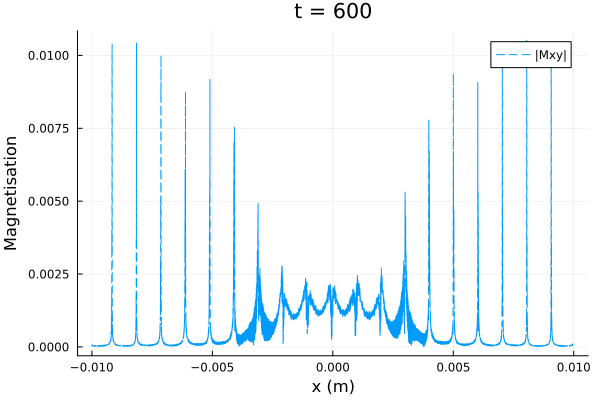

In [9]:
N_voxels = 10001
N_samples = 1

data_reshaped = Array{eltype(sig_clean)}(undef, 1000, N_samples, N_voxels)

for v in 1:N_voxels
    for s in 1:N_samples
        idx = (s - 1) * N_voxels + v   # every 201st element
        data_reshaped[:, s, v] = sig_clean[:, idx]
    end
end

data_summed = sum(data_reshaped, dims=2)   
data_summed   = dropdims(data_summed; dims=2) 

t_idx = 600
Mxy_t = data_summed[t_idx, :]
Mmag = abs.(Mxy_t)

p = plot(x_pos, Mmag, label="|Mxy|", linestyle=:dash, ylabel="Magnetisation", xlabel="x (m)", title="t = $(t_idx)")

display(p)

In [ ]:
# slice_thickness = 10e-3  
# inside_mask = abs.(x_pos) .<= (slice_thickness / 2)
# outside_mask = .!inside_mask

# S_total   = sum(Mxy_t)
# S_inside  = sum(Mxy_t[inside_mask])
# S_outside = sum(Mxy_t[outside_mask])

# println("Complex signal:   ", S_total, "          mag: ", abs(S_total))
# println("--> inside ±5mm:    ", S_inside, "         mag: ", abs(S_inside))
# println("--> outside ±5mm:   ", S_outside, "       mag: ", abs(S_outside))
# println(abs(S_outside) / abs(S_total) * 100)

In [ ]:
# Ratio outside/inside at each time point
ratios_per_t = [
    abs(sum(data_summed[t, outside_mask])) /
    abs(sum(data_summed[t, inside_mask]))
    for t in 1:size(data_summed, 1)
]
sum_ratio = sum(ratios_per_t)
average_percent = sum_ratio/1000 * 100

println()
#println("Average of outside/inside ratios over all time points: ", average_percent)

In [ ]:
using Statistics # Sum of *inside* spins at each timepoint
inside_signal_per_t = [
    abs(sum(data_summed[t, inside_mask]))
    for t in 1:size(data_summed, 1)
]

# Average magnitude of inside signal
mean_inside = mean(inside_signal_per_t)

println("Average coherent inside signal magnitude: ", round(mean_inside, digits=4))


In [ ]:
function simulate_slice_profile_x(
    seq::Sequence; x=range(-2.e-2, 2.e-2, 200), sim_params=Dict{String,Any}("Δt_rf" => 1e-6)
)
    sim_params["return_type"] = "state"
    sys = Scanner()
    obj = Phantom{Float64}(; x=Array(x), z=zeros(size(x)))
    mag = simulate(obj, seq, sys; sim_params)
    return mag
end
z = -0.01:0.000001:0.01
slice_prof= simulate_slice_profile_x(seq[3]; x=z)

In [ ]:
scaled_profile = abs.(slice_prof.xy) .* (maximum(Mmag) / maximum(abs.(slice_prof.xy)))

plot(x_pos, Mmag, label="|Mxy|", linestyle=:dash,
     ylabel="Magnetisation", xlabel="x (m)", title="t = $(t_idx)")
plot!(z, scaled_profile, label="Slice profile (scaled)")


In [ ]:
plot(abs.(signal))